In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [10]:
TRAIN_DATA_PATH = "data/train"
TEST_DATA_PATH = "data/test"
VAL_DATA_PATH = "data/val"

BATCH_SIZE = 8
NUM_WORKERS = 4

In [24]:
def show_random_image(path):
    random_image_name = np.random.choice(os.listdir(path))
    image = mpimg.imread(os.path.join(path, random_image_name))
    plt.figure(figsize=(4, 5))
    plt.title(os.path.join(path, random_image_name))
    # plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")
    plt.imshow(image)
    plt.show() 

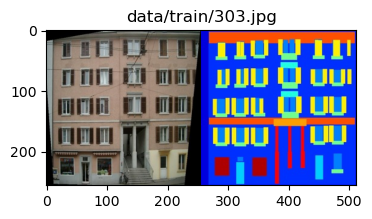

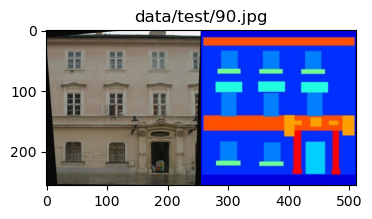

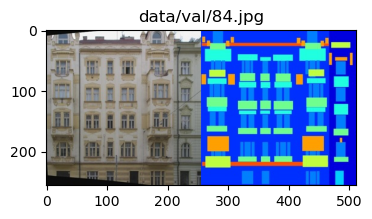

In [25]:
show_random_image(TRAIN_DATA_PATH)
show_random_image(TEST_DATA_PATH)
show_random_image(VAL_DATA_PATH)

In [13]:
class FacadeDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.n_samples = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.n_samples)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        image_name = self.n_samples[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = np.asarray(Image.open(image_path).convert("RGB"))
        height, width, _ = image.shape
        width_cutoff = width // 2
        real_image = image[:, :width_cutoff, :]
        input_image = image[:, width_cutoff:, :]
        sample = {
            "input_image": input_image, 
            "real_image": real_image
        }
        
        if self.transform:
            sample = self.transform(sample)  
        
        return sample


In [14]:
class Resize:
    
    def __init__(self, output_size=284):
        self.output_size = output_size

    def __call__(self, sample):
        sample["input_image"] = cv2.resize(
            sample["input_image"], (self.output_size, self.output_size)
        )
        sample["real_image"] = cv2.resize(
            sample["real_image"], (self.output_size, self.output_size)
        )
        return sample
    
    
class RandomCrop:
    
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        h, w = sample["real_image"].shape[:2]
        top = np.random.randint(0, h - self.output_size)
        left = np.random.randint(0, w - self.output_size)
        sample["input_image"] = sample["input_image"][
            top: top + self.output_size,
            left: left + self.output_size
        ]  
        sample["real_image"] = sample["real_image"][
            top: top + self.output_size,
            left: left + self.output_size
        ]
        return sample
    

class RandomHorizontalFlip:
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        if np.random.random() > self.p:
            sample["input_image"] = cv2.flip(sample["input_image"], 1)
            sample["real_image"] = cv2.flip(sample["real_image"], 1)
        return sample
    
    
class ToTensor:
    # numpy image: H x W x C
    # torch image: C x H x W
    def __call__(self, sample):
        sample["input_image"] = sample["input_image"].transpose((2, 0, 1))
        sample["input_image"] = torch.from_numpy(sample["input_image"])
        sample["real_image"] = sample["real_image"].transpose((2, 0, 1))
        sample["real_image"] = torch.from_numpy(sample["real_image"])
        return sample
    

In [15]:
train_transform = transforms.Compose(
    [
        Resize(284), 
        RandomCrop(256),
        RandomHorizontalFlip(0.5),
        ToTensor(),
    ]
)

train_facade_dataset = FacadeDataset(root_dir=TRAIN_DATA_PATH, transform=train_transform)

train_dataloader = DataLoader(
    train_facade_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    drop_last=True,
    num_workers=NUM_WORKERS,
)

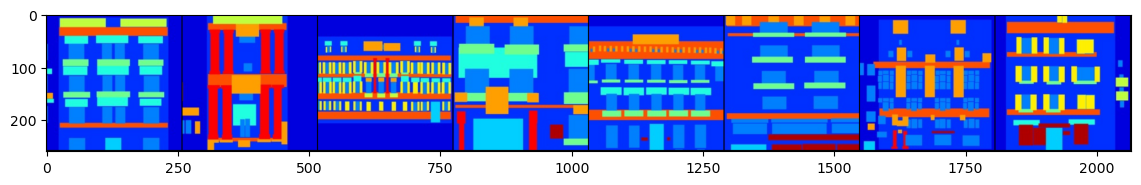

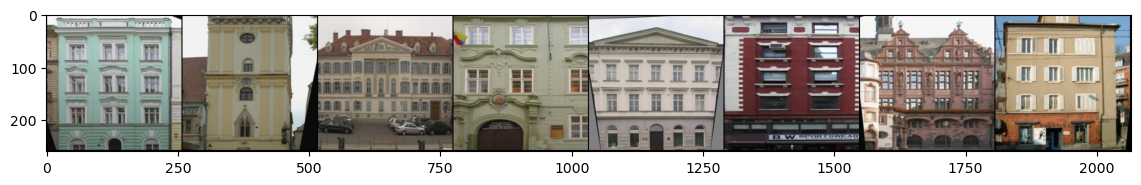

In [21]:
for batch in train_dataloader:
    input_image_batch, real_image_batch = batch["input_image"] / 255, batch["real_image"] / 255
    grid = utils.make_grid(input_image_batch)
    plt.figure(figsize=(14, 5))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    grid = utils.make_grid(real_image_batch)
    plt.figure(figsize=(14, 5))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break